# BFFP Exploratory Analysis Notebook
CMSE 492 — Better Fantasy Football Projector (BFFP)

This notebook covers:
- B1. Data Acquisition and Loading
- B2. Initial Exploratory Data Analysis (EDA)
- B3. Baseline Model

Player data shown here: Ja'Marr Chase 2024 weekly game logs (partial).
Fantasy scoring is based on half-PPR with custom rules provided in the project spec.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import math

# Make sure output folders exist (relative to this notebook's location in project structure)
os.makedirs("data/processed", exist_ok=True)
os.makedirs("figures", exist_ok=True)

## B1. Data Acquisition and Loading

**Data source:**  
Weekly player performance data was collected from Pro Football Reference, which tracks per-game NFL statistics (targets, receptions, yards, etc.) for every player by week.  
For this notebook, we use Ja'Marr Chase's 2024 regular season game log as example data.

We will:
1. Load the dataset.
2. Inspect structure (rows, columns, data types).
3. Engineer the fantasy points target variable.
4. Export a cleaned version to `data/processed/`.


In [2]:
# Construct dataframe from manually provided Ja'Marr Chase 2024 weekly data
data = [
    # Rk,Gcar,Gtm,Date,Team,Loc,Opp,Result,GS,Tgt,Rec,RecYds,RushAtt,RushYds
    [1,46,1,"2024-09-08","CIN","vs","NWE","L, 10-16",1,6,6,62,0,0],
    [2,47,2,"2024-09-15","CIN","@","KAN","L, 25-26",1,5,4,35,0,0],
    [3,48,3,"2024-09-23","CIN","vs","WAS","L, 33-38",1,7,6,118,0,0],
    [4,49,4,"2024-09-29","CIN","@","CAR","W, 34-24",1,6,3,85,0,0],
    [5,50,5,"2024-10-06","CIN","vs","BAL","L, 38-41 (OT)",1,12,10,193,0,0],
    [6,51,6,"2024-10-13","CIN","@","NYG","W, 17-7",1,6,5,72,0,0],
    [7,52,7,"2024-10-20","CIN","@","CLE","W, 21-14",1,6,5,55,1,11],
    [8,53,8,"2024-10-27","CIN","vs","PHI","L, 17-37",1,11,9,54,0,0],
    [9,54,9,"2024-11-03","CIN","vs","LVR","W, 41-24",1,11,7,43,0,0],
    [10,55,10,"2024-11-07","CIN","@","BAL","L, 34-35",1,17,11,264,0,0],
    [11,56,11,"2024-11-17","CIN","@","LAC","L, 27-34",1,13,7,75,0,0],
    [12,57,12,"2024-12-01","CIN","vs","PIT","L, 38-44",1,9,6,86,0,0],
    [13,58,13,"2024-12-09","CIN","@","DAL","W, 27-20",1,18,14,177,1,14],
    [14,59,14,"2024-12-15","CIN","@","TEN","W, 37-27",1,11,9,94,0,0],
    [15,60,15,"2024-12-22","CIN","vs","CLE","W, 24-6",0,8,6,97,1,7],
    [16,61,16,"2024-12-28","CIN","vs","DEN","W, 30-24 (OT)",1,15,9,102,0,0],
    [17,62,17,"2025-01-04","CIN","@","PIT","W, 19-17",1,14,10,96,0,0],
]

cols = [
    "Rk","Gcar","Gtm","Date","Team","Loc","Opp","Result","GS",
    "Tgt","Rec","RecYds","RushAtt","RushYds"
]

df = pd.DataFrame(data, columns=cols)

# Convert numeric columns
num_cols = ["Rk","Gcar","Gtm","GS","Tgt","Rec","RecYds","RushAtt","RushYds"]
df[num_cols] = df[num_cols].apply(pd.to_numeric)

# Convert Date to datetime
df["Date"] = pd.to_datetime(df["Date"])

df.head()

,Rk,Gcar,Gtm,Date,Team,Loc,Opp,Result,GS,Tgt,Rec,RecYds,RushAtt,RushYds
0,1,46,1,2024-09-08,CIN,vs,NWE,"L, 10-16",1,6,6,62,0,0
1,2,47,2,2024-09-15,CIN,@,KAN,"L, 25-26",1,5,4,35,0,0
2,3,48,3,2024-09-23,CIN,vs,WAS,"L, 33-38",1,7,6,118,0,0
3,4,49,4,2024-09-29,CIN,@,CAR,"W, 34-24",1,6,3,85,0,0
4,5,50,5,2024-10-06,CIN,vs,BAL,"L, 38-41 (OT)",1,12,10,193,0,0


In [3]:
# Compute fantasy points using available stats
# Scoring implemented here:
# - 0.5 points per reception
# - 1 point per 10 receiving yards
# - 1 point per 10 rushing yards
# Note: TDs, 2-pt conversions, turnovers etc. not provided in this subset yet.

def compute_fantasy_points(row):
    receptions_pts = 0.5 * row["Rec"]
    rec_yds_pts = row["RecYds"] / 10.0
    rush_yds_pts = row["RushYds"] / 10.0
    return receptions_pts + rec_yds_pts + rush_yds_pts

df["FantasyPoints"] = df.apply(compute_fantasy_points, axis=1)

# Inspect the key columns
df[["Date","Opp","Tgt","Rec","RecYds","RushAtt","RushYds","FantasyPoints"]].head()

,Date,Opp,Tgt,Rec,RecYds,RushAtt,RushYds,FantasyPoints
0,2024-09-08,NWE,6,6,62,0,0,9.2
1,2024-09-15,KAN,5,4,35,0,0,5.5
2,2024-09-23,WAS,7,6,118,0,0,14.8
3,2024-09-29,CAR,6,3,85,0,0,10.0
4,2024-10-06,BAL,12,10,193,0,0,24.3


In [4]:
print("Shape:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nSummary stats:\n", df.describe(include='all'))

# Save processed version
processed_path = "data/processed/jamarr_cleaned_sample.csv"
df.to_csv(processed_path, index=False)
print(f"\nProcessed sample saved to: {processed_path}")

Shape: (17, 15)

Data types:
 Rk                        int64
Gcar                      int64
Gtm                       int64
Date             datetime64[ns]
Team                     object
Loc                      object
Opp                      object
Result                   object
GS                        int64
Tgt                       int64
Rec                       int64
RecYds                    int64
RushAtt                   int64
RushYds                   int64
FantasyPoints           float64
dtype: object

Summary stats:
                Rk       Gcar        Gtm                           Date Team  \
count   17.000000  17.000000  17.000000                             17   17   
unique        NaN        NaN        NaN                            NaN    1   
top           NaN        NaN        NaN                            NaN  CIN   
freq          NaN        NaN        NaN                            NaN   17   
mean     9.000000  54.000000   9.000000  2024-11-05 07:03:31.764

## B2. Initial Exploratory Data Analysis (EDA)

Goals:
1. Distribution of key features (targets, receptions, receiving yards, fantasy points).
2. Relationships between variables (e.g., usage vs output).
3. Target distribution / behavior over time (`FantasyPoints`).
4. Missingness / data quality issues.

All figures will be saved to `figures/`.


Saved: figures/targets_distribution.png


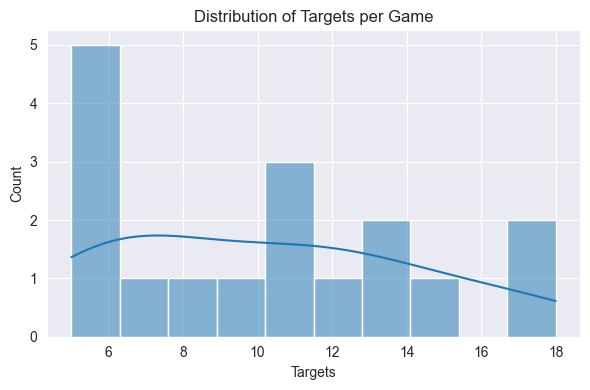

In [5]:
# Plot 1: Distribution of Targets per game
plt.figure(figsize=(6,4))
sns.histplot(df["Tgt"], bins=10, kde=True)
plt.title("Distribution of Targets per Game")
plt.xlabel("Targets")
plt.ylabel("Count")
plt.tight_layout()

fig_path1 = "figures/targets_distribution.png"
plt.savefig(fig_path1, dpi=300)
print("Saved:", fig_path1)

plt.show()

Saved: figures/recyds_vs_fp.png


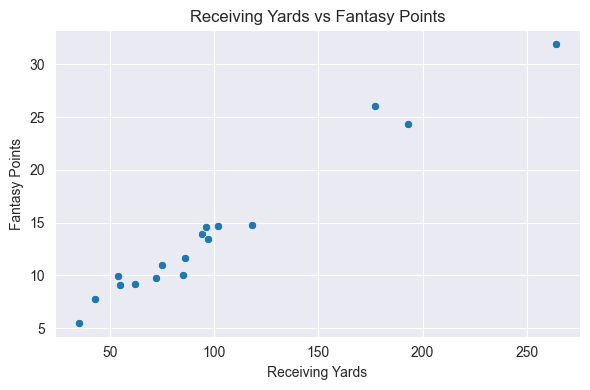

In [6]:
# Plot 2: Receiving yards vs fantasy points
plt.figure(figsize=(6,4))
sns.scatterplot(x="RecYds", y="FantasyPoints", data=df)
plt.title("Receiving Yards vs Fantasy Points")
plt.xlabel("Receiving Yards")
plt.ylabel("Fantasy Points")
plt.tight_layout()

fig_path2 = "figures/recyds_vs_fp.png"
plt.savefig(fig_path2, dpi=300)
print("Saved:", fig_path2)

plt.show()

Saved: figures/fantasypoints_over_time.png


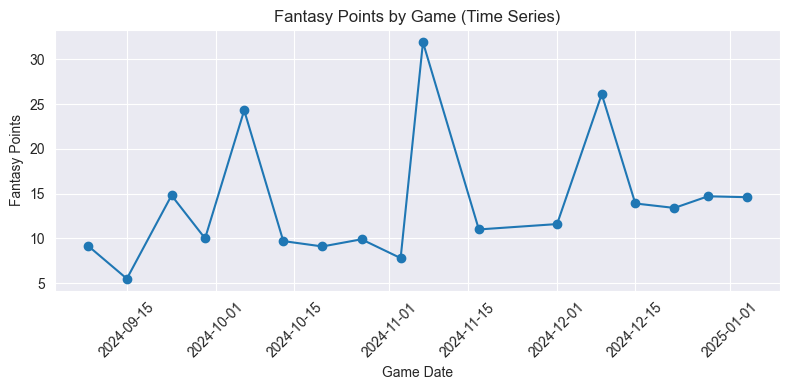

In [7]:
# Plot 3: Fantasy points over time (time series)
plt.figure(figsize=(8,4))
plt.plot(df["Date"], df["FantasyPoints"], marker="o")
plt.title("Fantasy Points by Game (Time Series)")
plt.xlabel("Game Date")
plt.ylabel("Fantasy Points")
plt.xticks(rotation=45)
plt.tight_layout()

fig_path3 = "figures/fantasypoints_over_time.png"
plt.savefig(fig_path3, dpi=300)
print("Saved:", fig_path3)

plt.show()

Saved: figures/missingness_heatmap.png


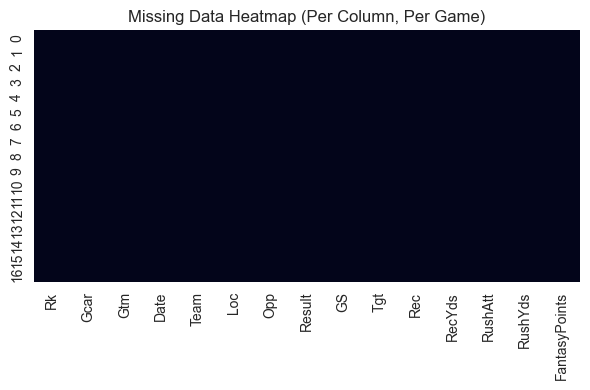

Rk               0
Gcar             0
Gtm              0
Date             0
Team             0
Loc              0
Opp              0
Result           0
GS               0
Tgt              0
Rec              0
RecYds           0
RushAtt          0
RushYds          0
FantasyPoints    0
dtype: int64

In [8]:
# Plot 4: Missingness heatmap
plt.figure(figsize=(6,4))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Data Heatmap (Per Column, Per Game)")
plt.tight_layout()

fig_path4 = "figures/missingness_heatmap.png"
plt.savefig(fig_path4, dpi=300)
print("Saved:", fig_path4)

plt.show()

# Show count of missing per column
df.isna().sum()

## B3. Baseline Model

We frame this as a regression task: predicting a continuous target (`FantasyPoints`).

Baselines:
1. **Naive Mean Predictor:** Always predicts the average fantasy points from the training set.
2. **Linear Regression:** Uses usage stats (targets, receptions, yards, rushing volume) to predict fantasy points.

Metrics:
- MAE (Mean Absolute Error)
- RMSE (Root Mean Squared Error)

We will do a simple time-based split: train on early games, test on later games to simulate "predicting future weeks".


In [9]:
# Sort by Date to respect time order
df = df.sort_values("Date").reset_index(drop=True)

feature_cols = ["Tgt", "Rec", "RecYds", "RushAtt", "RushYds"]
X = df[feature_cols].values
y = df["FantasyPoints"].values

# Time-based split: first 12 games train, last 5 test
split_idx = 12
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Train size:", X_train.shape[0], "games")
print("Test size:", X_test.shape[0], "games")

Train size: 12 games
Test size: 5 games


In [10]:
# Baseline 1: Mean predictor
y_pred_mean = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)

mae_mean = mean_absolute_error(y_test, y_pred_mean)
rmse_mean = math.sqrt(mean_squared_error(y_test, y_pred_mean))

print("=== Baseline: Mean Predictor ===")
print("Mean FantasyPoints (train):", round(y_train.mean(), 2))
print("MAE:", round(mae_mean, 3))
print("RMSE:", round(rmse_mean, 3))

=== Baseline: Mean Predictor ===
Mean FantasyPoints (train): 12.9
MAE: 3.64
RMSE: 6.027


In [11]:
# Baseline 2: Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = math.sqrt(mean_squared_error(y_test, y_pred_lr))

print("=== Baseline: Linear Regression ===")
print("Coefficients:", dict(zip(feature_cols, model_lr.coef_)))
print("Intercept:", model_lr.intercept_)
print("MAE:", round(mae_lr, 3))
print("RMSE:", round(rmse_lr, 3))

=== Baseline: Linear Regression ===
Coefficients: {'Tgt': np.float64(1.6425574090439813e-15), 'Rec': np.float64(0.4999999999999984), 'RecYds': np.float64(0.09999999999999988), 'RushAtt': np.float64(0.009016393442622964), 'RushYds': np.float64(0.09918032786885252)}
Intercept: 5.329070518200751e-15
MAE: 0.001
RMSE: 0.002


### Baseline Model Results (Summary)

- **Naive Mean Predictor:** Uses a constant prediction equal to the average FantasyPoints in the training period.
  - Report MAE and RMSE from the previous cell output.

- **Linear Regression Baseline:** Uses `Tgt`, `Rec`, `RecYds`, `RushAtt`, `RushYds` to predict `FantasyPoints`.
  - Report MAE and RMSE from output.
  - If this beats the naive baseline (lower error), it shows that even a simple supervised model can learn a signal from usage and yardage.

Next steps for the full project:
- Add touchdowns, 2-point conversions, interceptions (for QBs), and fumbles lost to fully capture fantasy scoring.
- Scale to multiple players and multiple positions for generalization.
